In [8]:
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm
import os
import random

os.chdir('/home/david/Desktop/projects/thesis/downstream_classification/')


In [3]:
os.listdir('./data/mit-bih/raw/')[:5]


['04126.atr', '00735.qrs', '04908.qrs', '04126.hea', '07879.atr']

In [4]:
source_folder = './data/mit-bih/raw/'
target_folder = './data/mit-bih/processed/'
files_in_source = {x.split('.')[0] for x in os.listdir(source_folder)}
files_in_source.remove('ANNOTATORS')
files_in_source.remove('RECORDS')
files_in_source.remove('SHA256SUMS')
files_in_source.remove('notes')
files_in_source.remove('old')
files_in_source

{'00735',
 '03665',
 '04015',
 '04043',
 '04048',
 '04126',
 '04746',
 '04908',
 '04936',
 '05091',
 '05121',
 '05261',
 '06426',
 '06453',
 '06995',
 '07162',
 '07859',
 '07879',
 '07910',
 '08215',
 '08219',
 '08378',
 '08405',
 '08434',
 '08455'}

# Get general info from one signal

Original signal shape: (9205760, 2)


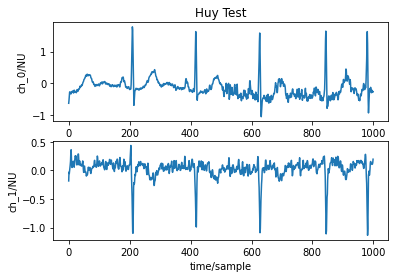

signals: [[-0.635 -0.185]
 [-0.54  -0.03 ]
 [-0.395 -0.055]
 ...
 [-0.3    0.015]
 [-0.27   0.025]
 [-0.27   0.02 ]]
fields: {'fs': 250, 'sig_len': 9205760, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(12, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []}
PQRS locs: [209 417 626 843 981]
Label intervals:
['(N:104', '(AFIB:2162708', '(N:2163556', '(AFIB:4057942', '(N:4062020']


In [4]:
import wfdb
import matplotlib.pyplot as plt

def MIT_BIH_get_signal_info(path, verbosity=False):
    """
    path: path to signal, without extension (hea, or atr, for example).
    verbosity: plot file
    """

    # read signal
    signals, fields = wfdb.rdsamp(path)
    
    if verbosity:
        print('Original signal shape:', signals.shape)
        # Display it with the additional information
        wfdb.plot_items(signal=signals[:1000,:], fs=fields['fs'], title='Huy Test')
        plt.show()
        print('signals:', signals)
        print('fields:', fields)
    
    # qrs annotation
    if os.path.exists(path+'.qrs'):
        pqrs_locs = wfdb.rdann(path, 'qrs')
        print('PQRS locs:', pqrs_locs.sample[:5])
    
    # target anotations
    if os.path.exists(path+'.atr'):
        label_intervals = wfdb.rdann(path, 'atr')
        print('Label intervals:')
        print([f'{x}:{y}' for (x,y) in zip(label_intervals.aux_note[:5], label_intervals.sample[:5])])
    
    return signals, fields, pqrs_locs, label_intervals

def MIT_BIH_plit_into_intervals(signal,label_intervals):
    """
    get signal and annotatnion and return dict with labels and intervals
    """
    
    labels = label_intervals.aux_note
    intervals = label_intervals.sample
    num_intervals = len(labels)

    results = []

    for j in range(num_intervals-1):
        label = labels[j]
        interval_min = intervals[j]
        interval_max = intervals[j+1]
        results.append((label,signal[interval_min:interval_max]))

    # right tale
    label = labels[j+1]
    interval_min = intervals[j+1]
    interval_max = len(signal)
    results.append((label,signal[interval_min:interval_max]))

    return results

def MIT_BIH_data_saver(intervals, target_dir, reading_num):
    for j, inter in enumerate(intervals):
        interval_label  = inter[0].replace('(','')
        interval_signal = inter[1]
        with open(target_dir+f'{reading_num}_interval_{j}_labeled_{interval_label}.npy', 'wb') as f:
            np.save(f, interval_signal)

reading_num='05261'    
signals, fields, pqrs_locs, label_intervals = MIT_BIH_get_signal_info(f'./data/mit-bih/raw/{reading_num}', verbosity=True)
intervals = MIT_BIH_plit_into_intervals(signals, label_intervals)
MIT_BIH_data_saver(intervals=intervals, target_dir=target_folder, reading_num=reading_num)

# test

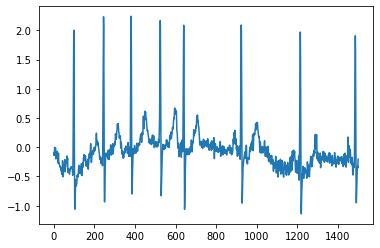

In [5]:
with open(target_folder+'05261_interval_22_labeled_N.npy', 'rb') as f:
    a = np.load(f)
plt.plot(a[:1500,0])

# Save All

In [6]:
for fname in tqdm(files_in_source):
    try:
        reading_num=fname
        signals, fields, pqrs_locs, label_intervals = MIT_BIH_get_signal_info(f'./data/mit-bih/raw/{reading_num}', verbosity=False)
        intervals = MIT_BIH_plit_into_intervals(signals, label_intervals)
        MIT_BIH_data_saver(intervals=intervals, target_dir=target_folder, reading_num=reading_num)
    except: 
        continue

  0%|          | 0/25 [00:00<?, ?it/s]

PQRS locs: [187 395 592 789 988]
Label intervals:
['(N:93', '(AFL:604953', '(N:724335', '(AFIB:742007', '(N:2281342']


  4%|▍         | 1/25 [00:00<00:22,  1.08it/s]

PQRS locs: [209 417 626 843 981]
Label intervals:
['(N:104', '(AFIB:2162708', '(N:2163556', '(AFIB:4057942', '(N:4062020']


 12%|█▏        | 3/25 [00:02<00:17,  1.23it/s]

PQRS locs: [ 348  581  710 1003 1181]
Label intervals:
['(AFIB:174']


 16%|█▌        | 4/25 [00:03<00:18,  1.14it/s]

PQRS locs: [145 340 452 729 921]
Label intervals:
['(N:72', '(AFIB:2545096', '(N:2549499', '(AFIB:2562781']
PQRS locs: [ 61 200 358 584 729]
Label intervals:
['(N:30', '(AFIB:102584', '(N:119604', '(AFIB:121773', '(N:122194']


 20%|██        | 5/25 [00:05<00:26,  1.31s/it]

PQRS locs: [ 158  402  651  912 1160]
Label intervals:
['(N:79', '(AFIB:1633050', '(N:1633999', '(AFIB:1900120', '(N:1901525']


 28%|██▊       | 7/25 [00:08<00:22,  1.24s/it]

PQRS locs: [ 207  466  724  984 1243]
Label intervals:
['(N:103', '(AFIB:806384', '(N:864893', '(AFIB:1758668', '(AFL:1760363']


 32%|███▏      | 8/25 [00:08<00:18,  1.11s/it]

PQRS locs: [ 317  518  704  886 1067]
Label intervals:
['(N:158', '(AFIB:1774708', '(AFL:3204435', '(AFIB:3216995']
PQRS locs: [ 108  357  569  819 1021]
Label intervals:
['(N:54', '(AFIB:1783080', '(J:7333067', '(AFIB:7334783', '(N:7335468']


 40%|████      | 10/25 [00:10<00:15,  1.00s/it]

PQRS locs: [193 390 586 782 905]
Label intervals:
['(N:96', '(AFIB:2808396', '(N:2820743', '(AFIB:2850351']


 44%|████▍     | 11/25 [00:11<00:14,  1.06s/it]

PQRS locs: [136 276 416 557 696]
Label intervals:
['(N:68', '(AFIB:266498', '(N:376328', '(AFIB:2585284', '(N:2602516']


 48%|████▊     | 12/25 [00:21<00:43,  3.36s/it]

PQRS locs: [ 85 309 529 742 963]
Label intervals:
['(N:42', '(AFIB:413691', '(N:447761', '(AFIB:1023430', '(N:1027876']


 56%|█████▌    | 14/25 [00:23<00:24,  2.23s/it]

PQRS locs: [ 15 174 353 510 689]
Label intervals:
['(AFIB:7', '(AFL:1381607', '(AFIB:1383575', '(AFL:1387965', '(AFIB:1389204']
PQRS locs: [ 74 221 359 478 601]
Label intervals:
['(AFIB:37', '(N:526603', '(AFIB:534235', '(N:556304', '(AFIB:580089']


 60%|██████    | 15/25 [00:24<00:18,  1.88s/it]

PQRS locs: [ 345  492  760  915 1007]
Label intervals:
['(N:172', '(AFIB:3077924', '(N:3126813', '(AFIB:3144896', '(N:3236450']


 68%|██████▊   | 17/25 [00:26<00:11,  1.42s/it]

PQRS locs: [109 318 526 729 939]
Label intervals:
['(N:54', '(AFIB:2237188', '(N:2315413', '(AFIB:2321489', '(N:2489167']
PQRS locs: [ 309  504  700  892 1085]
Label intervals:
['(N:154', '(AFIB:11388', '(N:138152', '(AFIB:171592', '(N:191328']


 72%|███████▏  | 18/25 [00:27<00:08,  1.28s/it]

PQRS locs: [ 352  569  778  989 1204]
Label intervals:
['(N:176', '(AFIB:556677', '(N:580971', '(AFIB:716110', '(N:724076']


 80%|████████  | 20/25 [00:29<00:05,  1.08s/it]

PQRS locs: [ 124  357  583  809 1033]
Label intervals:
['(N:62', '(AFIB:1097510', '(N:1098684', '(AFIB:2284261', '(N:2285672']
PQRS locs: [ 300  503  713  919 1117]
Label intervals:
['(N:150', '(AFIB:763937', '(N:767747', '(AFIB:926994', '(N:934174']


 88%|████████▊ | 22/25 [00:31<00:02,  1.02it/s]

PQRS locs: [139 276 423 578 708]
Label intervals:
['(AFIB:43']
PQRS locs: [ 39 198 357 512 663]
Label intervals:
['(N:19', '(AFIB:1227217', '(N:1329239', '(AFIB:1744908', '(N:1945251']


 96%|█████████▌| 24/25 [00:33<00:01,  1.07s/it]

PQRS locs: [ 56 242 440 632 823]
Label intervals:
['(N:28', '(AFIB:1843491', '(N:1844115', '(AFIB:1849414', '(N:2305445']


100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


# Split

In [32]:
signal_indices = list({x.split('_')[0] for x in os.listdir(target_folder)})
random.shuffle(signal_indices)

print('Num Readings (Total):', len(signal_indices))
test_size = int(0.2*len(signal_indices))

training_readings = signal_indices[:-test_size]
test_readings = signal_indices[-test_size:]

print('Readings in Train:', len(training_readings))
print('Readings in Test:', len(test_readings))

Num Readings (Total): 21
Readings in Train: 17
Readings in Test: 4


In [33]:
print('Training')
print(training_readings)
print('Test')
print(test_readings)


Training
['08434', '06426', '08455', '08405', '04015', '08219', '08378', '08215', '07910', '04908', '07879', '06995', '04936', '05121', '04126', '05091', '04043']
Test
['04746', '05261', '06453', '04048']


In [34]:
split = {
    'train':training_readings,
    'test':test_readings
         }
split

{'train': ['08434',
  '06426',
  '08455',
  '08405',
  '04015',
  '08219',
  '08378',
  '08215',
  '07910',
  '04908',
  '07879',
  '06995',
  '04936',
  '05121',
  '04126',
  '05091',
  '04043'],
 'test': ['04746', '05261', '06453', '04048']}

In [38]:
import json 
    
# Convert and write JSON object to file
with open(target_folder+"splits.json", "w") as outfile: 
    json.dump(split, outfile)
    

In [41]:
target_folder

'./data/mit-bih/processed/'

In [40]:
with open(target_folder+"splits.json") as json_file:
    data = json.load(json_file)

data

{'train': ['08434',
  '06426',
  '08455',
  '08405',
  '04015',
  '08219',
  '08378',
  '08215',
  '07910',
  '04908',
  '07879',
  '06995',
  '04936',
  '05121',
  '04126',
  '05091',
  '04043'],
 'test': ['04746', '05261', '06453', '04048']}